<a href="https://colab.research.google.com/github/mequanent/HCC-2022/blob/main/Recommendation%20Sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc

from collections import defaultdict

# synthesize data
NUM_USERS = 10_000
NUM_ITEMS = 1_000
user_id = np.arange(start = 0, stop = NUM_USERS)
item_id = np.arange(start = 0, stop = NUM_ITEMS)
np.random.seed(42)

user_item_dict = defaultdict(list)
genres = ['Action','Comedy','Drama','Fantasy','Horror','Mystery','Romance','Thriller','Western']
for id in user_id:
    
    # random the number of item generation
    # for each user, random 3 to 5 items to be rated.
    num_rand_item = np.random.randint(low = 3, high = 5)

    # random from the item_id
    rand_items = np.random.choice(item_id, size = num_rand_item, replace = False)

    # random rating for each itme_id
    rand_rating = np.random.randint(low = 1, high = 10, size = num_rand_item)

    # collect the user-item paris.
    for uid, iid,rating in zip([id] * num_rand_item, rand_items, rand_rating):
        user_item_dict['user_id'].append(uid)
        user_item_dict['item_id'].append(iid)
        user_item_dict['rating'].append(rating)

# prepare dataframe
ratings = pd.DataFrame(user_item_dict)
print("Rating Dataframe")
ratings[['user_id','item_id']] = ratings[['user_id','item_id']].astype(str)
display(ratings.head())

item_genre_dict = defaultdict(list)
for iid in item_id:

    # random number of genres
    num_rand_genre = np.random.randint(low = 1, high = 3)
    # random set of genres
    rand_genres = np.random.choice(genres, size = num_rand_genre, replace = False)
    item_genre_dict['item_id'].append(iid)
    item_genre_dict['genres'].append(', '.join(list(rand_genres)))

# prepare dataframe
items = pd.DataFrame(item_genre_dict)
print("\nItem Dataframe")
items = items.astype(str)
display(items.head())

Rating Dataframe


,user_id,item_id,rating
0,0,521,2
1,0,941,8
2,0,741,2
3,1,986,5
4,1,275,5



Item Dataframe


,item_id,genres
0,0,"Romance, Action"
1,1,Mystery
2,2,"Drama, Western"
3,3,"Fantasy, Horror"
4,4,"Comedy, Drama"


# Popularity based

**Introduction**

For any machine learning problems, we need a baseline model or method to use as a reference whether our approach is good or not.

Our machine learning prediction or sophsticated analysis should, at least, beat those baseline performance.

For recommendation system, we can make a simple baseline score with popular item recommendation

To define the popularity of the item, there have a metrics called weighted rating system that is used to score the rating of each movie.

Here is the formula

```
(WR) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C
```
Where
- R = average rating for the movie. (rating)
- v = number of votes for the movie. (members)
- m = minimum votes required to be listed in the Top 250 (defined by > percentile 80 of total votes)
- C = the average rating across the whole dataset.

**Drawback**

- It's not personalized. All the users will get the same exact list of popularity based recommendation.

**Action**

- For new users, if we don't have any information about them we can provide the list based on ranking the vote_count or weighted_rating as a best guess.
In real world, this is the result when you see the section "Popular on Netflix"

**Reference**

- [IMDB rating system](https://help.imdb.com/article/imdb/track-movies-tv/ratings-faq/G67Y87TFYYP6TWAV?ref_=helpms_helpart_inline#)

In [10]:
def weighted_rating(v,m,R,C):
    '''
    Calculate the weighted rating
    
    Args:
    v -> average rating for each item (float)
    m -> minimum votes required to be classified as popular (float)
    R -> average rating for the item (pd.Series)
    C -> average rating for the whole dataset (pd.Series)
    
    Returns:
    pd.Series
    '''
    return ( (v / (v + m)) * R) + ( (m / (v + m)) * C )

def assign_popular_based_score(rating_df, item_df, user_col, item_col, rating_col):
    '''
    Assigned popular based score based on the IMDB weighted average.
    
    Args:
    rating -> pd.DataFrame contains ['item_id', 'rating'] for each user.
    
    Returns
    popular_items -> pd.DataFrame contains item and IMDB weighted score.
    '''
    
    # pre processing
    vote_count = (
        rating_df
        .groupby(item_col,as_index=False)
        .agg( {user_col:'count', rating_col:'mean'} )
        )
    vote_count.columns = [item_col, 'vote_count', 'avg_rating']
    
    # calcuate input parameters
    C = np.mean(vote_count['avg_rating'])
    m = np.percentile(vote_count['vote_count'], 70)
    vote_count = vote_count[vote_count['vote_count'] >= m]
    R = vote_count['avg_rating']
    v = vote_count['vote_count']
    vote_count['weighted_rating'] = weighted_rating(v,m,R,C)
    
    # post processing
    vote_count = vote_count.merge(item_df, on = [item_col], how = 'left')
    popular_items = vote_count.loc[:,[item_col, 'genres', 'vote_count', 'avg_rating', 'weighted_rating']]
    
    return popular_items

In [12]:
# init constant
USER_COL = 'user_id'
ITEM_COL = 'item_id'
RATING_COL = 'rating'

# calcualte popularity based
pop_items = assign_popular_based_score(ratings, items, USER_COL, ITEM_COL, RATING_COL)
pop_items = pop_items.sort_values('weighted_rating', ascending = False)
pop_items

,item_id,genres,vote_count,avg_rating,weighted_rating
117,404,Mystery,39,6.153846,5.588628
186,597,Mystery,42,5.976190,5.516554
206,646,Romance,38,6.000000,5.504268
113,392,"Romance, Action",45,5.911111,5.497884
3,109,"Fantasy, Thriller",44,5.886364,5.479565
...,...,...,...,...,...
273,840,"Mystery, Fantasy",38,4.000000,4.504268
135,448,Fantasy,44,4.068182,4.503955
180,578,Comedy,40,3.975000,4.478517
306,925,Drama,38,3.868421,4.438478


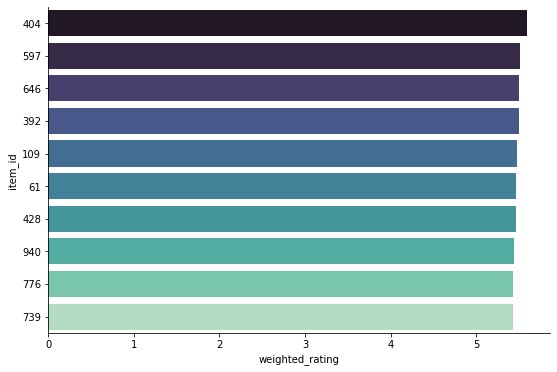

In [6]:
# plot the popularity based on the weighted score
fix, ax = plt.subplots(figsize=(9,6))
sns.barplot(data = pop_items.head(10),
            y = 'item_id',
            x = 'weighted_rating',
            palette = 'mako');
sns.despine();

# Content based 

**Introduction**

For example, if a person has liked the movie “Inception”, then this algorithm will recommend movies that fall under the same genre.

Here we create a better way of recommendation by introducing other features of the content into our engine.

It's an improvement compared to the popularity based recommendation we mentioned earlier.

Now, the customer who read, watch, or like any kinds of specific products will get a recommendation based on the product they interacted in the past.

Consider the example of Netflix. They save all the information related to each user in a vector form. This vector contains the past behavior of the user, i.e. the movies liked/disliked by the user and the ratings given by them. This vector is known as the profile vector. All the information related to movies is stored in another vector called the item vector. Item vector contains the details of each movie, like genre, cast, director, etc. The content-based filtering algorithm finds the cosine of the angle between the profile vector and item vector, i.e. cosine similarity.

**Drawback**

A major drawback of this algorithm is that it is limited to recommending items that are of the same type.
It will never recommend products which the user has not bought or liked in the past. So if a user has watched or liked only action movies in the past, the system will recommend only action movies.

**Reference**

[Building a movie content based recommender using tf-idf](https://towardsdatascience.com/content-based-recommender-systems-28a1dbd858f5)

In [16]:
from sklearn.metrics.pairwise import cosine_similarity

def top_k_items(item_id, top_k, corr_mat, map_name):
    
    # sort correlation value ascendingly and select top_k item_id
    top_items = corr_mat[item_id,:].argsort()[-top_k:][::-1] 
    top_items = [map_name[e] for e in top_items] 

    return top_items
items

,item_id,genres
0,0,"Romance, Action"
1,1,Mystery
2,2,"Drama, Western"
3,3,"Fantasy, Horror"
4,4,"Comedy, Drama"
...,...,...
995,995,Western
996,996,Comedy
997,997,Drama
998,998,"Romance, Comedy"


In [51]:
# preprocessing
rated_items = items.loc[items[ITEM_COL].isin(ratings[ITEM_COL])].copy()

# extract the genre
genre = rated_items['genres'].str.split(",", expand=True)
rated_items
genre

,0,1
0,Romance,Action
1,Mystery,None
2,Drama,Western
3,Fantasy,Horror
4,Comedy,Drama
...,...,...
995,Western,None
996,Comedy,None
997,Drama,None
998,Romance,Comedy


In [52]:
# get all possible genre
all_genre = set()
for c in genre.columns:
    distinct_genre = genre[c].str.lower().str.strip().unique()
    all_genre.update(distinct_genre)    
all_genre.remove(None)
all_genre

{'action',
 'comedy',
 'drama',
 'fantasy',
 'horror',
 'mystery',
 'romance',
 'thriller',
 'western'}

In [53]:
# create item-genre matrix
item_genre_mat = rated_items[[ITEM_COL, 'genres']].copy()
item_genre_mat['genres'] = item_genre_mat['genres'].str.lower().str.strip()
item_genre_mat

,item_id,genres
0,0,"romance, action"
1,1,mystery
2,2,"drama, western"
3,3,"fantasy, horror"
4,4,"comedy, drama"
...,...,...
995,995,western
996,996,comedy
997,997,drama
998,998,"romance, comedy"


In [54]:
# OHE the genres column
for genre in all_genre:
    item_genre_mat[genre] = np.where(item_genre_mat['genres'].str.contains(genre), 1, 0)
item_genre_mat

,item_id,genres,western,romance,drama,comedy,mystery,horror,action,fantasy,thriller
0,0,"romance, action",0,1,0,0,0,0,1,0,0
1,1,mystery,0,0,0,0,1,0,0,0,0
2,2,"drama, western",1,0,1,0,0,0,0,0,0
3,3,"fantasy, horror",0,0,0,0,0,1,0,1,0
4,4,"comedy, drama",0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
995,995,western,1,0,0,0,0,0,0,0,0
996,996,comedy,0,0,0,1,0,0,0,0,0
997,997,drama,0,0,1,0,0,0,0,0,0
998,998,"romance, comedy",0,1,0,1,0,0,0,0,0


In [56]:
item_genre_mat.drop(['genres'], axis = 1)

,item_id,western,romance,drama,comedy,mystery,horror,action,fantasy,thriller
0,0,0,1,0,0,0,0,1,0,0
1,1,0,0,0,0,1,0,0,0,0
2,2,1,0,1,0,0,0,0,0,0
3,3,0,0,0,0,0,1,0,1,0
4,4,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
995,995,1,0,0,0,0,0,0,0,0
996,996,0,0,0,1,0,0,0,0,0
997,997,0,0,1,0,0,0,0,0,0
998,998,0,1,0,1,0,0,0,0,0


In [59]:
# OHE the genres column
for genre in all_genre:
    item_genre_mat[genre] = np.where(item_genre_mat['genres'].str.contains(genre), 1, 0)
item_genre_mat = item_genre_mat.drop(['genres'], axis=1)
item_genre_mat = item_genre_mat.set_index(ITEM_COL)
item_genre_mat

,western,romance,drama,comedy,mystery,horror,action,fantasy,thriller
item_id,,,,,,,,,
0,0,1,0,0,0,0,1,0,0
1,0,0,0,0,1,0,0,0,0
2,1,0,1,0,0,0,0,0,0
3,0,0,0,0,0,1,0,1,0
4,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
995,1,0,0,0,0,0,0,0,0
996,0,0,0,1,0,0,0,0,0
997,0,0,1,0,0,0,0,0,0


In [69]:
# compute similarity matix
corr_mat = cosine_similarity(item_genre_mat)
# get top-k similar items
ind2name = {ind:name for ind,name in enumerate(item_genre_mat.index)}
name2ind = {v:k for k,v in ind2name.items()}
similar_items = top_k_items(name2ind['99'],
                            top_k = 10,
                            corr_mat = corr_mat,
                            map_name = ind2name)
# display result
print("The top-k similar movie to item_id 899")
display(items.loc[items[ITEM_COL].isin(similar_items)])

The top-k similar movie to item_id 899


,item_id,genres
0,0,"Romance, Action"
99,99,"Romance, Action"
211,211,"Romance, Action"
352,352,"Romance, Action"
512,512,"Action, Romance"
618,618,"Romance, Action"
737,737,"Action, Romance"
744,744,"Romance, Action"
813,813,"Action, Romance"
858,858,"Romance, Action"


In [7]:
# OHE the genres column
for genre in all_genre:
    item_genre_mat[genre] = np.where(item_genre_mat['genres'].str.contains(genre), 1, 0)
item_genre_mat = item_genre_mat.drop(['genres'], axis=1)
item_genre_mat = item_genre_mat.set_index(ITEM_COL)

# compute similarity matix
corr_mat = cosine_similarity(item_genre_mat)

# get top-k similar items
ind2name = {ind:name for ind,name in enumerate(item_genre_mat.index)}
name2ind = {v:k for k,v in ind2name.items()}
similar_items = top_k_items(name2ind['99'],
                            top_k = 10,
                            corr_mat = corr_mat,
                            map_name = ind2name)

# display result
print("The top-k similar movie to item_id 99")
display(items.loc[items[ITEM_COL].isin(similar_items)])

del corr_mat
gc.collect();

The top-k similar movie to item_id 99


,item_id,genres
0,0,"Romance, Action"
99,99,"Romance, Action"
211,211,"Romance, Action"
352,352,"Romance, Action"
512,512,"Action, Romance"
618,618,"Romance, Action"
737,737,"Action, Romance"
744,744,"Romance, Action"
813,813,"Action, Romance"
858,858,"Romance, Action"


Summary

As we expect, all the similar items interm of genre is in the top-k recommendation.

# Collaborative filtering

**Introduction**

The collaborative filtering algorithm uses “User Behavior” for recommending items. This is one of the most commonly used algorithms in the industry as it is not dependent on any additional information.

There are 2 ways we can make a prediction using the collaborative filtering technique.

1. User based - The user-similarity matrix will consist of some distance metric that measures the similarity between any two pairs of users.
This algorithm is useful when the number of users is less. Its not effective when there are a large number of users as it will take a lot of time to compute the similarity between all user pairs. This leads us to item-item collaborative filtering, which is effective when the number of users is more than the items being recommended.

2. Item based - Likewise, the item-similarity matrix will measure the similarity between any two pairs of items.

**Drawback**

What will happen if a new user or a new item is added in the dataset? The answer is we can't make a prediction for that user or item because we don't have enough "User behavior" information. This problem is called a Cold Start. 

There are two types of cold start.
1. User - Since there is no history of that user, the system does not know the preferences of that user
These can be determined by what has been popular recently overall or regionally.

2. Item - More the interaction a product receives, the easier it is for our model to recommend that product to the right user.
We can make use of Content based filtering to solve this problem.

## 3.1 Memory based approache

**Introduction**

The key difference of memory-based approach from the model-based techniques is that we are not learning any parameter using gradient descent (or any other optimization algorithm). The closest user or items are calculated only by using Cosine similarity or Pearson correlation coefficients, which are only based on arithmetic operations. various-implementations-of-collaborative-filtering

Memory-based methods use user rating historical data to compute the similarity between users or items. The idea behind these methods is to define a similarity measure between users or items, and find the most similar to recommend unseen items. Building a memory based collaborative filtering recommender

**Drawback**

It's not scalable due to the sprasity of the data.
We needs to construct the similarity matrix everytime the new user comes. (Hard to maintain, and operationalize)

**Action**

- The list result can be showed in the front-end application like "Made for you" -> Provide the list of recommended items.
- The list result can be showed in the front-end application like "Because you like item" -> Provided the list of recommended items.


In [81]:
from scipy.sparse import csr_matrix

# preprocess data
row = ratings[USER_COL]
col = ratings[ITEM_COL]
data = ratings[RATING_COL]
mat = csr_matrix((data, (row, col)), shape=(NUM_USERS, NUM_ITEMS))
mat.eliminate_zeros()
sparsity = float(len(mat.nonzero()[0]))
sparsity /= (mat.shape[0] * mat.shape[1])
sparsity

0.0034953

In [82]:
# calculate sparsity
sparsity = float(len(mat.nonzero()[0]))
sparsity /= (mat.shape[0] * mat.shape[1])
sparsity *= 100
print(f'Sparsity: {sparsity:4.2f}%. This means that {sparsity:4.2f}% of the user-item ratings have a value.')

Sparsity: 0.35%. This means that 0.35% of the user-item ratings have a value.


In [11]:
# Together
from scipy.sparse import csr_matrix

# preprocess data
row = ratings[USER_COL]
col = ratings[ITEM_COL]
data = ratings[RATING_COL]

# init user-item matrix
mat = csr_matrix((data, (row, col)), shape=(NUM_USERS, NUM_ITEMS))
mat.eliminate_zeros()

# calculate sparsity
sparsity = float(len(mat.nonzero()[0]))
sparsity /= (mat.shape[0] * mat.shape[1])
sparsity *= 100
print(f'Sparsity: {sparsity:4.2f}%. This means that {sparsity:4.2f}% of the user-item ratings have a value.')

# compute similarity
item_corr_mat = cosine_similarity(mat.T)

# get top k item
print("\nThe top-k similar movie to item_id 99")
similar_items = top_k_items(name2ind['99'],
                            top_k = 10,
                            corr_mat = item_corr_mat,
                            map_name = ind2name)

display(items.loc[items[ITEM_COL].isin(similar_items)])

Sparsity: 0.35%. This means that 0.35% of the user-item ratings have a value.

The top-k similar movie to item_id 99


,item_id,genres
99,99,"Romance, Action"
248,248,Horror
352,352,"Romance, Action"
392,392,"Romance, Action"
507,507,"Horror, Western"
570,570,Horror
730,730,Fantasy
757,757,"Romance, Thriller"
824,824,Fantasy
899,899,Comedy


Summary

Now, we will get the different set of result from the content-based. The similaity between items has been calculated based on the "User-behavior" rather than the attributes of the items.

## 3.2 Model-based approach¶

**Introduction**

Model-based CF uses machine learning algorithms to predict users’ rating of unrated items. 
There are many model-based CF algorithms, the most commonly used are matrix factorization models such as to applying a SVD to reconstruct the rating matrix, latent Dirichlet allocation or Markov decision process based models. Building a memory based collaborative filtering recommender

**Type**

- Matrix Factorization (MF) based
    1. TruncatedSVD (Sklearn)
    2. Funk MF (Surprise)
    3. Non negative MF (Surprise)
- Deep learning MF based
    1. Generalizaed MF (Keras)
    2. Neural Collaborative filtering (Recommenders)

In [95]:
from sklearn.decomposition import TruncatedSVD

epsilon = 1e-9
n_latent_factors = 10

# calculate item latent matrix
item_svd = TruncatedSVD(n_components = n_latent_factors)
item_features = item_svd.fit_transform(mat.transpose()) + epsilon
print(len(item_features))
print(len(item_features[0]))
print(item_features[0])

1000
10
[ 1.26599123 -0.6861438   0.25322959 -0.0813158  -0.72994283  0.03307244
 -0.218306   -0.35228133 -0.2737926   0.35105839]


In [97]:
# calculate user latent matrix
user_svd = TruncatedSVD(n_components = n_latent_factors)
user_features = user_svd.fit_transform(mat) + epsilon
print(len(user_features))
print(len(user_features[0]))
print(user_features[0])

10000
10
[ 0.49517952  0.46144801 -0.22408438  1.36371054  0.07558084 -0.1563441
  0.20095952  0.5741448   0.44286657 -0.07946639]


In [98]:
# compute similarity
item_corr_mat = cosine_similarity(item_features)
item_corr_mat

array([[ 1.        ,  0.53212321,  0.2364985 , ...,  0.42068572,
         0.43485611,  0.36755865],
       [ 0.53212321,  1.        ,  0.38397585, ...,  0.55095865,
         0.42670311, -0.02747878],
       [ 0.2364985 ,  0.38397585,  1.        , ...,  0.49682316,
         0.25444921,  0.31331071],
       ...,
       [ 0.42068572,  0.55095865,  0.49682316, ...,  1.        ,
         0.02928752, -0.1280074 ],
       [ 0.43485611,  0.42670311,  0.25444921, ...,  0.02928752,
         1.        ,  0.47962581],
       [ 0.36755865, -0.02747878,  0.31331071, ..., -0.1280074 ,
         0.47962581,  1.        ]])

### 3.2.1 TrucatedSVD

In [101]:
# Different recommendations observed for the same item in running again and again ---?
from sklearn.decomposition import TruncatedSVD

epsilon = 1e-9
n_latent_factors = 10

# calculate item latent matrix
item_svd = TruncatedSVD(n_components = n_latent_factors)
item_features = item_svd.fit_transform(mat.transpose()) + epsilon

# calculate user latent matrix
user_svd = TruncatedSVD(n_components = n_latent_factors)
user_features = user_svd.fit_transform(mat) + epsilon

# compute similarity
item_corr_mat = cosine_similarity(item_features)

# get top k item
print("\nThe top-k similar movie to item_id 99")
similar_items = top_k_items(name2ind['99'],
                            top_k = 10,
                            corr_mat = item_corr_mat,
                            map_name = ind2name)

display(items.loc[items[ITEM_COL].isin(similar_items)])

del user_features
gc.collect();


The top-k similar movie to item_id 99


,item_id,genres
15,15,Thriller
28,28,"Action, Horror"
83,83,Horror
99,99,"Romance, Action"
569,569,Drama
627,627,Romance
857,857,Horror
869,869,Fantasy
952,952,"Western, Comedy"
962,962,Western


Summary

With this method, you can see that we can compute the similarity based on the specific number of latent factor.

Now, the recommendation would be based on some latent factors that we cannot explain directly.
But in mathematically speaking, it will be the top latent factor that minimize the loss between the Actual rating and Reconstructed rating.
You can see that now we reduce the size of matrix compared to the one in memory-based approach. however, it's still not good enough approach because eventually when the user, or item size growing with the time.
Soon it will reach the limitation of computation resouce as well.

### 3.2.2 Funk MF

In [103]:
!pip install scikit-surprise -q

     |████████████████████████████████| 11.8 MB 5.5 MB/s 


In [107]:
# Similar recommendations observed on repeated runs.
from surprise import SVD, accuracy
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate
from surprise.model_selection.split import train_test_split

def pred2dict(predictions, top_k=None):
    
    rec_dict = defaultdict(list)
    for user_id, item_id, actual_rating, pred_rating, _ in predictions:
        rec_dict[user_id].append((item_id, pred_rating))        
        
    return rec_dict

def get_top_k_recommendation(rec_dict, user_id, top_k, ind2name):
    
    pred_ratings = rec_dict[user_id]
    # sort descendingly by pred_rating
    pred_ratings = sorted(pred_ratings, key=lambda x: x[1], reverse=True)
    pred_ratings = pred_ratings[:top_k]
    recs = [ind2name[e[0]] for e in pred_ratings]
    
    return recs

# prepare train and test sets
reader = Reader(rating_scale=(1,10))
data = Dataset.load_from_df(ratings, reader)
train, test = train_test_split(data, test_size=.2, random_state=42)

# init and fit the funk mf model
algo = SVD(random_state = 42)
algo.fit(train)
pred = algo.test(test);

# evaluation the test set
accuracy.rmse(pred)

# extract the item features from algo
item_corr_mat = cosine_similarity(algo.qi)

print("\nThe top-k similar movie to item_id 99")
similar_items = top_k_items(name2ind['99'],
                            top_k = 10,
                            corr_mat = item_corr_mat,
                            map_name = ind2name)

display(items.loc[items[ITEM_COL].isin(similar_items)])

del item_corr_mat
gc.collect();

RMSE: 2.6256

The top-k similar movie to item_id 99


,item_id,genres
99,99,"Romance, Action"
114,114,"Thriller, Romance"
180,180,Comedy
194,194,Mystery
366,366,Action
546,546,"Action, Thriller"
599,599,Romance
611,611,"Drama, Comedy"
771,771,"Romance, Western"
801,801,Drama


Summary

Here we use the Funk MF algorithms to create the latent factors matrix, and now we can build both the user-based, item-based recommendation.
We also randomly split out some users from the train set into the test set for the validation purpose.

### 3.2.3 Deep learning MF - Generalized Matrix Factorization (MF)
Usually, in the MF method, we tried to learn the user-item interaction or tried to reconstruct the predicted rating with the inner product of the shared lated features.

Now, for the deep learning approach, we use the different internal engine which is the DNNs to estimate the user and item laten features. We estimate the shared latent feature minimizing the target loss function.

After that, we used the fitted model to predict the pair of item that each customer have never watched to see what to recommend next.



In [15]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets
!pip install -q scann

     |████████████████████████████████| 85 kB 3.5 MB/s 
     |████████████████████████████████| 462 kB 16.5 MB/s 
     |████████████████████████████████| 4.2 MB 7.8 MB/s 
     |████████████████████████████████| 10.7 MB 7.0 MB/s 


In [16]:
%tensorflow_version 2.x  # this line is not required unless you are in a notebook

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # this line is not required unless you are in a notebook`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [19]:
from IPython.display import clear_output

import tensorflow as tf
import tensorflow_recommenders as tfrs
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split

from typing import Dict, Text, Tuple

def df_to_ds(df):

    # convert pd.DataFrame to tf.data.Dataset
    ds = tf.data.Dataset.from_tensor_slices(
        (dict(df[['user_id','item_id']]), df['rating']))
    
    # convert Tuple[Dict[Text, tf.Tensor], tf.Tensor] to Dict[Text, tf.Tensor]
    ds = ds.map(lambda x, y: {
    'user_id' : x['user_id'],
    'item_id' : x['item_id'],
    'rating' : y
    })

    return ds.batch(256)

class RankingModel(keras.Model):

    def __init__(self, user_id, item_id, embedding_size):
        super().__init__()
        
        # user model
        input = keras.Input(shape=(), dtype=tf.string)
        x = keras.layers.StringLookup(
            vocabulary = user_id, mask_token = None
            )(input)
        output = keras.layers.Embedding(
            input_dim = len(user_id) + 1,
            output_dim = embedding_size,
            name = 'embedding'
        )(x)
        self.user_model = keras.Model(inputs = input,
                                      outputs = output,
                                      name = 'user_model')

        # item model
        input = keras.Input(shape=(), dtype=tf.string)
        x = keras.layers.StringLookup(
            vocabulary = item_id, mask_token = None
            )(input)
        output = keras.layers.Embedding(
            input_dim = len(item_id) + 1,
            output_dim = embedding_size,
            name = 'embedding'
        )(x)
        self.item_model = keras.Model(inputs = input,
                                  outputs = output,
                                  name = 'item_model')

        # rating model
        user_input = keras.Input(shape=(embedding_size,), name='user_emb')
        item_input = keras.Input(shape=(embedding_size,), name='item_emb')
        x = keras.layers.Concatenate(axis=1)([user_input, item_input])
        x = keras.layers.Dense(256, activation = 'relu')(x)
        x = keras.layers.Dense(64, activation = 'relu')(x)
        output = keras.layers.Dense(1)(x)
        
        self.rating_model = keras.Model(
            inputs = {
                'user_id' : user_input,
                'item_id' : item_input
            },
            outputs = output,
            name = 'rating_model'
        )

    def call(self, inputs: Dict[Text, tf.Tensor]) -> tf.Tensor:

        user_emb = self.user_model(inputs['user_id'])
        item_emb = self.item_model(inputs['item_id'])

        prediction = self.rating_model({
            'user_id' : user_emb,
            'item_id' : item_emb
        })
        
        return prediction

class GMFModel(tfrs.models.Model):

    def __init__(self, user_id, item_id, embedding_size):
        super().__init__()
        self.ranking_model = RankingModel(user_id, item_id, embedding_size)
        self.task = tfrs.tasks.Ranking(
            loss = keras.losses.MeanSquaredError(),
            metrics = [keras.metrics.RootMeanSquaredError()]
        )
    
    def call(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:
        
        return self.ranking_model(
            {
             'user_id' : features['user_id'], 
             'item_id' : features['item_id']
            })

    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:

        return self.task(labels = features.pop('rating'),
                         predictions = self.ranking_model(features))

# preprocess
train, test = train_test_split(ratings, train_size = .8, random_state=42)
train, test = df_to_ds(train), df_to_ds(test)

# # init model
embedding_size = 64
model = GMFModel(user_id.astype(str),
                 item_id.astype(str),
                 embedding_size)
model.compile(
    optimizer = keras.optimizers.Adagrad(learning_rate = .01)
)

# # fitting the model
model.fit(train, epochs=3, verbose=0)

# evaluate with the test data
result = model.evaluate(test, return_dict=True, verbose=0)
print("\nEvaluation on the test set:")
display(result)

# extract item embedding
item_emb = model.ranking_model.item_model.layers[-1].get_weights()[0]


item_corr_mat = cosine_similarity(item_emb)

print("\nThe top-k similar movie to item_id 99")
similar_items = top_k_items(name2ind['99'],
                            top_k = 10,
                            corr_mat = item_corr_mat,
                            map_name = ind2name)

display(items.loc[items[ITEM_COL].isin(similar_items)])

del item_corr_mat
gc.collect();


Evaluation on the test set:


{'loss': 6.114309310913086,
 'regularization_loss': 0,
 'root_mean_squared_error': 2.579273223876953,
 'total_loss': 6.114309310913086}


The top-k similar movie to item_id 99


,item_id,genres
48,48,Romance
99,99,"Romance, Action"
136,136,Mystery
142,142,"Action, Horror"
424,424,"Mystery, Comedy"
485,485,"Drama, Fantasy"
612,612,"Action, Horror"
660,660,Comedy
711,711,"Action, Mystery"
774,774,"Action, Drama"


### 3.2.4 Deep learning MF - Neural Collaborative Filtering (NCF)

Due to the library conflie, remove the implementation.